In [1]:
import os
import sys
import json
sys.path.insert(0, os.path.abspath('../'))
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SHIFT_WIDTH = 40
REG_JUMP = 2

In [3]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 256
PATIENCE = 100
NB_FEATURES = 2

In [4]:
loaded = np.load(f'./training_data/training_set_{SHIFT_WIDTH}_{REG_JUMP}.npz')
input_signals = loaded['input_signals']
input_labels = loaded['input_labels']
input_features = loaded['input_features']
input_reg_signals = loaded['input_reg_signals']
input_reg_labels = loaded['input_reg_labels']
count_0 = loaded['count_0']
count_1 = loaded['count_1']

total = count_0 + count_1
weight_for_0 = (1 / count_0) * (total / 2.0)
weight_for_1 = (1 / count_1) * (total / 2.0)
class_weight = {0: weight_for_0, 1:weight_for_1}

print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)
print(class_weight, count_0, count_1)
print(input_features.shape)

(1013, 47, 80) (1013,)
(3702, 47, 80) (3702,)
{0: 0.8014240506329113, 1: 1.3293963254593175} 632 381
(1013, 47)


In [5]:
input_signals = input_signals[:, :, input_signals.shape[-1]//2:]
input_reg_signals = input_reg_signals[:, :, input_signals.shape[-1]//2:]

INPUT_CLS_SHAPE = [-1, input_signals.shape[1], input_signals.shape[2], 1]
INPUT_REG_SHAPE = [-1, input_reg_signals.shape[1], input_reg_signals.shape[2], 1]

In [6]:
input_signals = input_signals.reshape(INPUT_CLS_SHAPE)
input_labels = input_labels.reshape(-1, 1)
input_reg_signals = input_reg_signals.reshape(INPUT_REG_SHAPE)
input_reg_labels = input_reg_labels.reshape(-1, 1)
input_features = input_features.reshape(-1, INPUT_CLS_SHAPE[1], 1)

train_input = []
train_label = []
train_feature = []
val_input = []
val_label = []
val_feature = []
cur_count_0 = 0
cur_count_1 = 0
for i in range(len(input_labels)):
    if input_labels[i] == 0:
        cur_count_0 += 1
        if cur_count_0 < int(count_0 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
            train_feature.append(input_features[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            val_feature.append(input_features[i])
    else:
        cur_count_1 += 1
        if cur_count_1 < int(count_1 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
            train_feature.append(input_features[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            val_feature.append(input_features[i])
            
train_input = np.array(train_input)
train_label = np.array(train_label)
train_feature = np.array(train_feature)
val_input = np.array(val_input)
val_label = np.array(val_label)
val_feature = np.array(val_feature)

train_reg_input = input_reg_signals[:int(input_reg_signals.shape[0] * 0.8)]
train_reg_label = input_reg_labels[:int(input_reg_labels.shape[0] * 0.8)]
val_reg_input = input_reg_signals[int(input_reg_signals.shape[0] * 0.8):]
val_reg_label = input_reg_labels[int(input_reg_labels.shape[0] * 0.8):]

In [7]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data, *args

In [8]:
train_input, train_label, train_feature = shuffle(train_input, train_label, train_feature)
val_input, val_label, val_feature = shuffle(val_input, val_label, val_feature)
train_reg_input, train_reg_label = shuffle(train_reg_input, train_reg_label)
val_reg_input, val_reg_label = shuffle(val_reg_input, val_reg_label)

In [11]:
@tf.keras.utils.register_keras_serializable(package='JSC')
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [10]:
"""
regression_model = Anomalous_regression()
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                             metrics=[tf.keras.metrics.MeanAbsoluteError(
                                 name='mean_absolute_error', dtype=None)]
                        ) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )
    
history = regression_model.fit(x=train_reg_tf,
                                   validation_data=val_reg_tf,
                                   epochs=MAX_EPOCHS,
                                   shuffle=True,
                                   callbacks=[early_stopping],
                                   verbose=2
                                  )
regression_model.save('regression_model_.keras')
"""

"\nregression_model = Anomalous_regression()\nregression_model.compile(loss=tf.keras.losses.MeanSquaredError(),\n                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),\n                             metrics=[tf.keras.metrics.MeanAbsoluteError(\n                                 name='mean_absolute_error', dtype=None)]\n                        ) \nearly_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                  patience=PATIENCE,\n                                                  mode='min',\n                                                  restore_best_weights=True,\n                                                 )\n    \nhistory = regression_model.fit(x=train_reg_tf,\n                                   validation_data=val_reg_tf,\n                                   epochs=MAX_EPOCHS,\n                                   shuffle=True,\n                                   callbacks=[early_stopping],\n  

In [12]:
"""
signal_input = keras.Input(shape=train_input_signal.shape[1:], name="signal")
feature_input = keras.Input(shape=(NB_FEATURES,), name="features")

x1 = layers.Flatten()(signal_input)
x1 = layers.Dense(units=1)(x1)
x1 = layers.ReLU()(x1)

x2 = layers.Dense(units=2)(feature_input)
x2 = layers.ReLU()(x2)
cls_concat = layers.concatenate([x1, x2])
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_concat)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)
"""

'\nsignal_input = keras.Input(shape=train_input_signal.shape[1:], name="signal")\nfeature_input = keras.Input(shape=(NB_FEATURES,), name="features")\n\nx1 = layers.Flatten()(signal_input)\nx1 = layers.Dense(units=1)(x1)\nx1 = layers.ReLU()(x1)\n\nx2 = layers.Dense(units=2)(feature_input)\nx2 = layers.ReLU()(x2)\ncls_concat = layers.concatenate([x1, x2])\ncls_last_layer = layers.Dense(units=1, activation=\'sigmoid\')(cls_concat)\n\ncls_model = keras.Model(\n    inputs=[signal_input, feature_input],\n    outputs=[cls_last_layer],\n    name=\'anomalous_detection\'\n)\n'

In [13]:
print(f'train_cls_shape:{train_input.shape}\n',
      f'train_feat_shape:{train_feature.shape}\n'
      f'val_cls_shape:{val_input.shape}\n',
      f'val_feat_shape:{val_feature.shape}\n'
      f'train_reg_shape:{train_reg_input.shape}\n',
      f'val_reg_shape:{val_reg_input.shape}\n',
     )

train_cls_shape:(807, 47, 40, 1)
 train_feat_shape:(807, 47, 1)
val_cls_shape:(206, 47, 40, 1)
 val_feat_shape:(206, 47, 1)
train_reg_shape:(2961, 47, 60, 1)
 val_reg_shape:(741, 47, 60, 1)



In [15]:
signal_input = keras.Input(shape=train_input.shape[1:], name="signals")
feature_input = keras.Input(shape=train_feature.shape[1:], name="features")

x1 = layers.ConvLSTM1D(filters=128, kernel_size=2, strides=1, padding='same', dropout=0.1)(signal_input)
x1 = layers.ReLU()(x1)
x1 = layers.Bidirectional(layers.LSTM(32))(x1)
x1 = layers.ReLU()(x1)
x1 = layers.Flatten()(x1)

x2 = layers.Dense(units=32)(feature_input)
x2 = layers.ReLU()(x2)
x2 = layers.Dense(units=32)(x2)
x2 = layers.ReLU()(x2)
x2 = layers.Flatten()(x2)
cls_concat = layers.concatenate([x1, x2])
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_concat)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)

In [16]:
cls_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='Acc'),
                           tf.keras.metrics.FalsePositives(name='FP'),
                           tf.keras.metrics.FalseNegatives(name='FN')]
                 )
cls_model.build(input_shape=INPUT_CLS_SHAPE[1:])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )

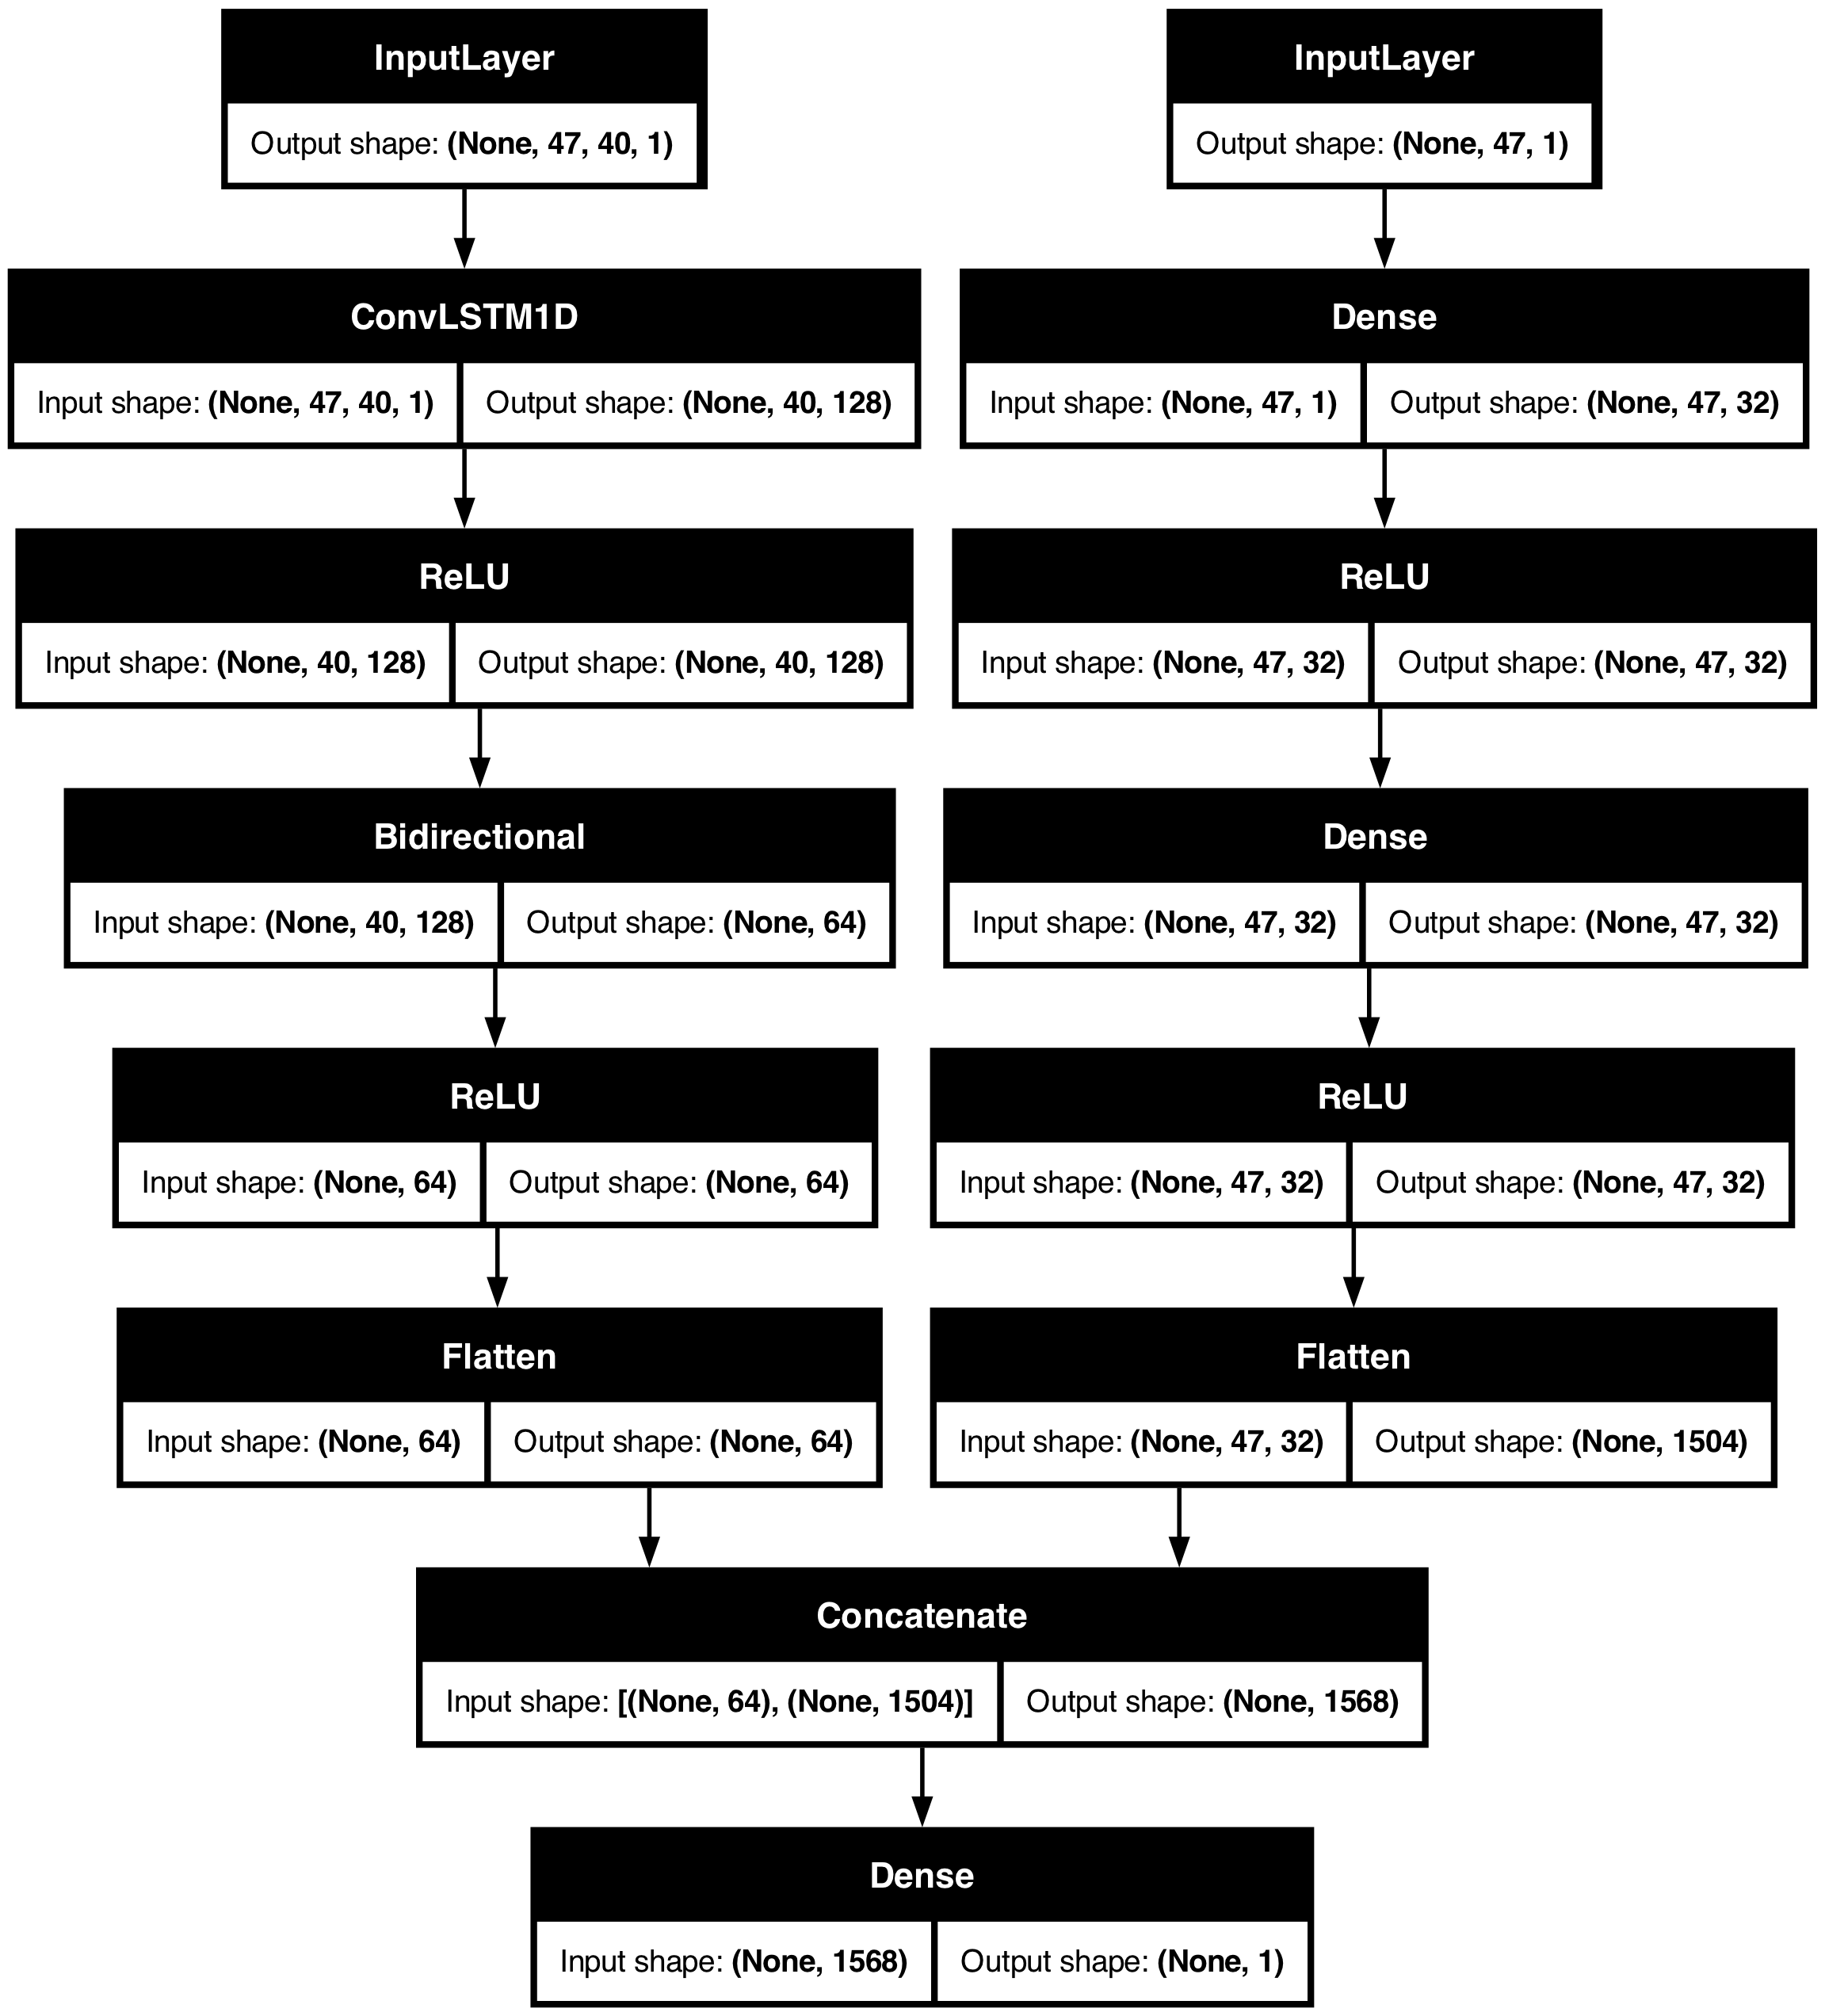

In [17]:
keras.utils.plot_model(cls_model, "cls_model.png", show_shapes=True)

In [18]:
cls_model.summary()

Model: "anomalous_detection"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signals             │ (None, 47, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 47, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm1d_1       │ (None, 40, 128)   │    132,608 │ signals[0][0]     │
│ (ConvLSTM1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 47, 32)    │         64 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 40, 128)   │          0 │ conv_lstm1d_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 47, 32)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ re_lu_4[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 47, 32)    │      1,056 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 47, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ re_lu_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1504)      │          0 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1568)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      1,569 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,513 (689.50 KB)

 Trainable params: 176,513 (689.50 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
cls_history = cls_model.fit(x=[train_input, train_feature],
                        y=train_label,
                        validation_data=([val_input, val_feature], val_label),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        class_weight=class_weight,
                        verbose=2
                       )
cls_model.save(f'./models/cls_model_{SHIFT_WIDTH}_{REG_JUMP}.keras')
history_dict = cls_history.history
json.dump(history_dict, open(f'./models/history_{SHIFT_WIDTH}_{REG_JUMP}.json', 'w'))

Epoch 1/10000


2024-05-11 15:03:12.781965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 - 33s - 8s/step - Acc: 0.4647 - JSC: 0.3975 - loss: 0.6906 - val_Acc: 0.6068 - val_JSC: 0.4564 - val_loss: 0.6873
Epoch 2/10000


KeyboardInterrupt: 